# Question 2

In [1]:
# Import modules
import pandas as pd
import shap
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

/Users/samanthayom/Desktop/MACS 30135 Explainable & Interpretable Machine Learning/Graded Exercises/Graded Exercise 1/macs30135-graded-exercise-1/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Provide data filenames
RAW_ADULT_DATA = "data/adult.csv"

## Data Preprocessing
Here, we load and preprocess the data, and split it into a training and test set.

In [3]:
df = pd.read_csv(RAW_ADULT_DATA)  # Load data to dataframe


print(f"No. of rows: {df.shape[0]}")
print(f"No. of columns: {df.shape[1]}")
df.head()


No. of rows: 32561
No. of columns: 15


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,NaN,Widowed,NaN,Not-in-family,White,Female,NaN,4356.0,40.0,United-States,<=50K
1,82,Private,132870,HS-grad,NaN,Widowed,Exec-managerial,Not-in-family,White,Female,NaN,4356.0,18.0,United-States,<=50K
2,66,NaN,186061,Some-college,10.0,Widowed,NaN,Unmarried,Black,Female,NaN,4356.0,40.0,United-States,<=50K
3,54,Private,140359,7th-8th,NaN,Divorced,Machine-op-inspct,Unmarried,White,Female,NaN,3900.0,40.0,United-States,<=50K
4,41,Private,264663,Some-college,10.0,Separated,Prof-specialty,Own-child,White,Female,NaN,3900.0,40.0,United-States,<=50K


We drop any rows containing missing data points. It was also mentioned in class that there are a number of rows in which the value of capital.gain is 99999, which is likely used to represent "NaN", so we drop these rows as well.

In [4]:
df = df[df["capital.gain"] != 99999.0]  # Remove rows where capital.gain = 99999.0
df["capital.gain"] = df["capital.gain"].fillna(0)  # Replace NaN values in capital.gain with 0
df["capital.loss"] = df["capital.loss"].fillna(0)  # Replace NaN values in capital.loss with 0

df["capital"] = df["capital.gain"] - df["capital.loss"]  # Create new column capital
df = df.drop(columns=["capital.gain", "capital.loss"]).dropna()  # Remove rows with missing values 

df = df.rename(columns={"income": "income.exceeds_50k" })   # Rename column income
df["income.exceeds_50k"] = df["income.exceeds_50k"].map({
    "<=50K": 0,
    ">50K": 1,
})  # Replace values in income column
print(df["income.exceeds_50k"].value_counts(), "\n")  # Print value counts of income column

print(f"No. of rows: {df.shape[0]}")
print(f"No. of columns: {df.shape[1]}")
df.head()

income.exceeds_50k
0    10791
1     5519
Name: count, dtype: int64 

No. of rows: 16310
No. of columns: 14


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,hours.per.week,native.country,income.exceeds_50k,capital
4,41,Private,264663,Some-college,10.0,Separated,Prof-specialty,Own-child,White,Female,40.0,United-States,0,-3900.0
7,74,State-gov,88638,Doctorate,16.0,Never-married,Prof-specialty,Other-relative,White,Female,20.0,United-States,1,-3683.0
10,45,Private,172274,Doctorate,16.0,Divorced,Prof-specialty,Unmarried,Black,Female,35.0,United-States,1,-3004.0
11,38,Self-emp-not-inc,164526,Prof-school,15.0,Never-married,Prof-specialty,Not-in-family,White,Male,45.0,United-States,1,-2824.0
12,52,Private,129177,Bachelors,13.0,Widowed,Other-service,Not-in-family,White,Female,20.0,United-States,1,-2824.0


In [5]:
# Specify categorical data and convert to their category codes, since SHAP cannot handle category data type
# https://xgboost.readthedocs.io/en/stable/tutorials/categorical.html#training-with-scikit-learn-interface
for col in df.columns:
    if df[col].dtype != "int64":
        df[col] = df[col].astype("category")
        df[col] = df[col].cat.codes

In [6]:
X = df.drop(columns=["income.exceeds_50k"])
y = df["income.exceeds_50k"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

## Model Fitting


In [7]:
highest_accuracy = 0
best_tree_method = None

# Iterate through all combinations of max_depth and learning_rate to find model with highest accuracy
for tree_method in ["approx", "hist"]:
    bst = XGBClassifier(
        tree_method=tree_method,
        objective="binary:logistic",
        enable_categorical=True, 
        seed=8
    )
    bst.fit(X_train, y_train)
    accuracy = bst.score(X_test, y_test)
    print(f"accuracy: {accuracy:.3f} | tree_method: {tree_method}")

    if accuracy > highest_accuracy:
        highest_accuracy = accuracy
        best_tree_method = tree_method
    
print(f"\nBest accuracy: {highest_accuracy:.3f} (tree method: {best_tree_method})")

accuracy: 0.837 | tree_method: approx
accuracy: 0.840 | tree_method: hist

Best accuracy: 0.840 (tree method: hist)


In [8]:
# Obtain model with best accuracy
bst = XGBClassifier(
        tree_method=best_tree_method,
        objective="binary:logistic",
        enable_categorical=True, 
        seed=8
    )
bst.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Model Interpretation


### Feature Importance
Here, we plot the feature importance in explaining our model's prediction of whether incomex exceeds $50k/year.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

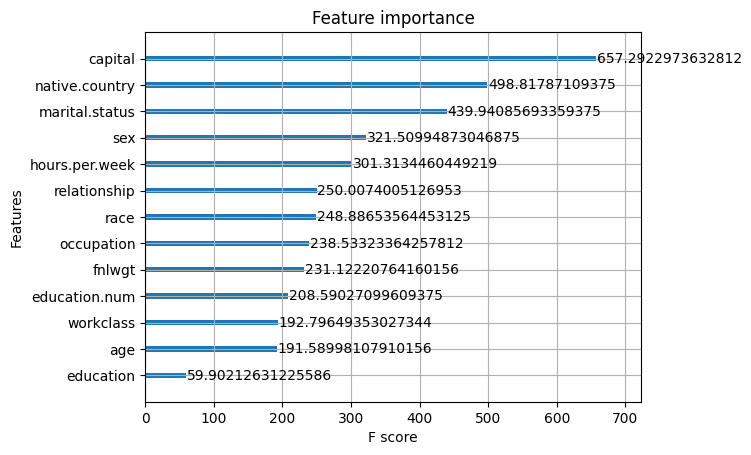

In [9]:
xgb.plot_importance(bst, importance_type="cover")

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

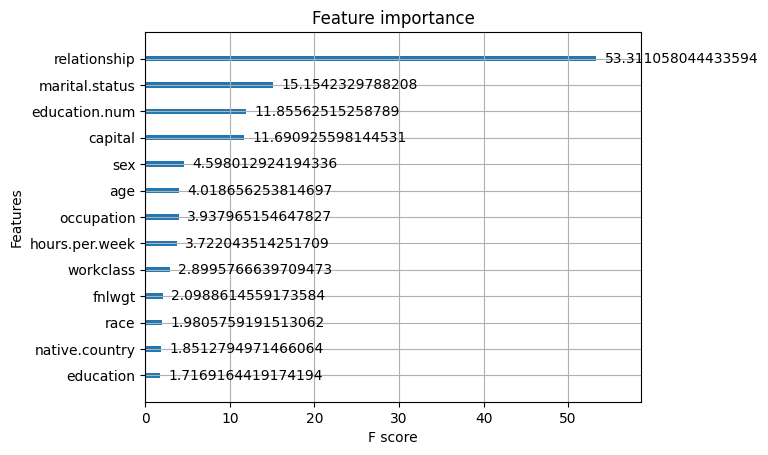

In [10]:
xgb.plot_importance(bst, importance_type="gain")

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

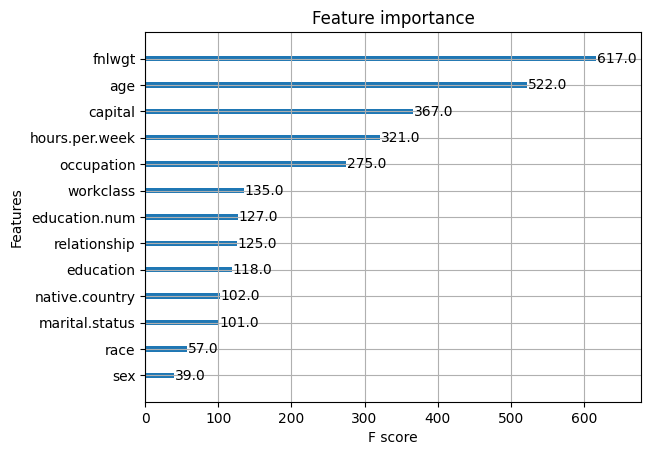

In [11]:
xgb.plot_importance(bst, importance_type="weight")

### SHAP Values

In [12]:
# Compute SHAP values
explainer = shap.Explainer(bst)
shap_values = explainer(X_test)

#### Global Plots

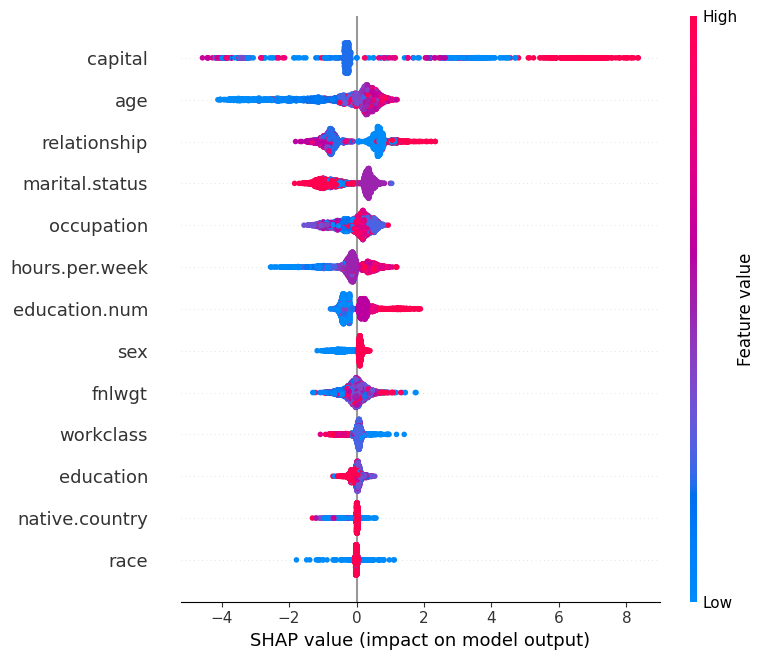

In [13]:
# Obtain summary plot
shap.summary_plot(shap_values, X_test)

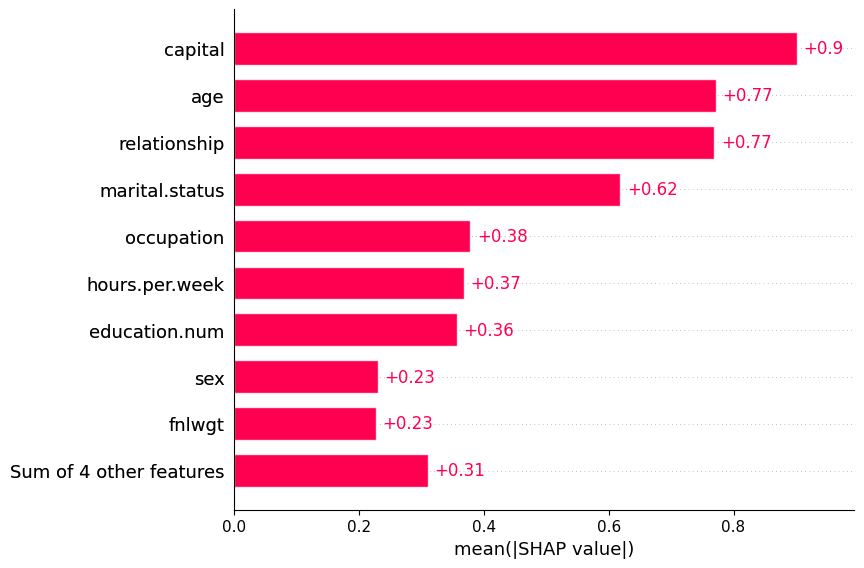

In [14]:
# Obtain global bar plot
shap.plots.bar(shap_values)

In [15]:
# Obtain force plot
shap.initjs()
shap.plots.force(shap_values)

/Users/samanthayom/Desktop/MACS 30135 Explainable & Interpretable Machine Learning/Graded Exercises/Graded Exercise 1/macs30135-graded-exercise-1/.venv/lib/python3.12/site-packages/shap/plots/_force.py:208: UserWarning: shap.plots.force is slow for many thousands of rows, try subsampling your data.
  warnings.warn("shap.plots.force is slow for many thousands of rows, try subsampling your data.")


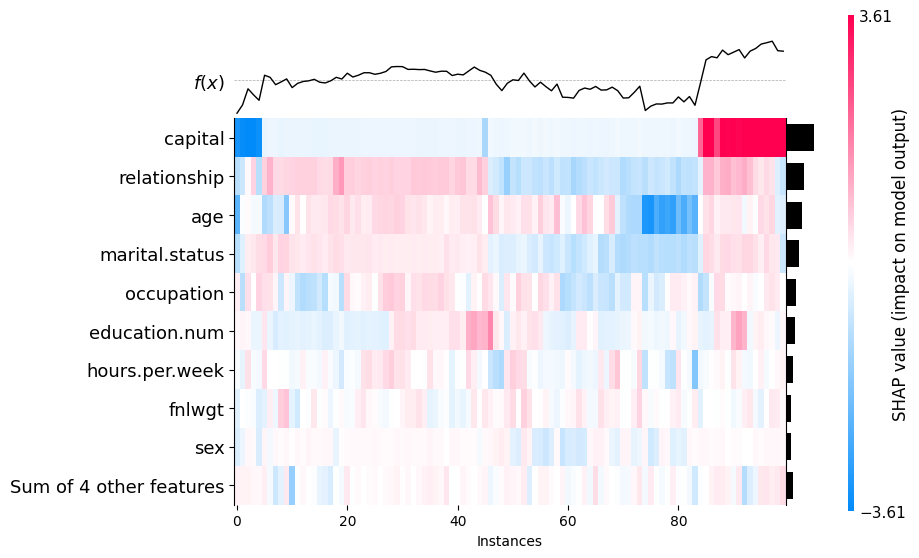

<Axes: xlabel='Instances'>

In [ ]:
# Obtain heatmap
shap.plots.heatmap(shap_values.sample(100), instance_order=X_test)

#### Feature Interaction

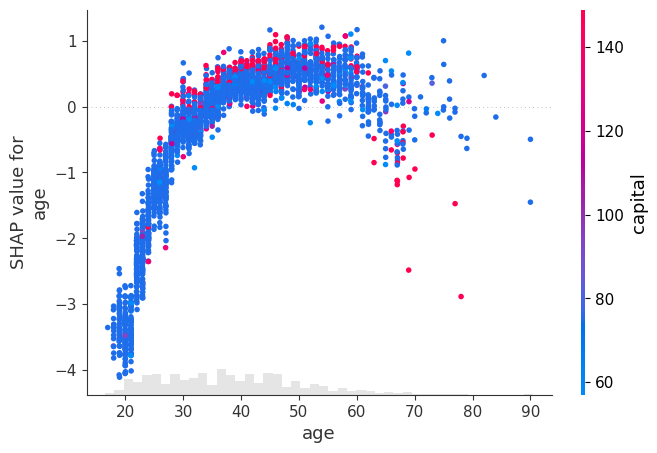

In [ ]:
# Obtain dependence plot
shap.plots.scatter(shap_values[:, "age"], color=shap_values[:, "capital"])